# tab 키로 함수 자동완성기능 추가

In [34]:
%config Completer.use_jedi = False   

In [35]:
import numpy as np
from dezero import Variable


이차미분이 마음데로 되네

In [36]:
def f(x):
    y = x ** 4
    return y

x = Variable(np.array(2.0))
y = f(x)
y.backward(create_graph=True)
print(x.grad)

gx = x.grad
x.cleargrad()
gx.backward()
print(x.grad)



variable(32.0)
variable(48.0)


연산자 오버로드 step22.py

들어온 변수가 스칼라인지 확인
def as_array(x): 
    if np.isscalar(x):
        return np.array(x)
    return x

매직 매소드
__pow__ : 소스에서는 Variable.__pow__ 방식으로 사용중
Variable 변수에서는 ** 연산시 pow 로 인식하여 사용하게됨

class Pow(Function):
    def __init__(self, c):
        self.c = c
    def forward(self, x):
        y = x ** self.c
        return y
    def backward(self, gy):
        x = self.inputs[0].data
        c = self.c
        gx = c * x ** (c - 1) * gy
        return gx


def pow(x, c):
    return Pow(c)(x)

Variable.__pow__ = pow

In [58]:
import weakref
import numpy as np
import contextlib


class Config:
    enable_backprop = True


@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)


def no_grad():
    return using_config('enable_backprop', False)


class Variable:
    __array_priority__ = 200

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref


def as_variable(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, *inputs):
        inputs = [as_variable(x) for x in inputs]

        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    x1 = as_array(x1)
    return Add()(x0, x1)


class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy * x1, gy * x0


def mul(x0, x1):
    x1 = as_array(x1)
    return Mul()(x0, x1)


class Neg(Function):
    def forward(self, x):
        return -x

    def backward(self, gy):
        return -gy


def neg(x):
    return Neg()(x)


class Sub(Function):
    def forward(self, x0, x1):
        y = x0 - x1
        return y

    def backward(self, gy):
        return gy, -gy


def sub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x0, x1)


def rsub(x0, x1):
    x1 = as_array(x1)
    return sub(x1, x0)


class Div(Function):
    def forward(self, x0, x1):
        y = x0 / x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        gx0 = gy / x1
        gx1 = gy * (-x0 / x1 ** 2)
        return gx0, gx1


def div(x0, x1):
    x1 = as_array(x1)
    return Div()(x0, x1)


def rdiv(x0, x1):
    x1 = as_array(x1)
    return div(x1, x0)


class Pow(Function):
    def __init__(self, c):
        self.c = c

    def forward(self, x):
        y = x ** self.c
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        c = self.c

        gx = c * x ** (c - 1) * gy
        return gx


def pow(x, c):
    return Pow(c)(x)


Variable.__add__ = add
Variable.__radd__ = add
Variable.__mul__ = mul
Variable.__rmul__ = mul
Variable.__neg__ = neg
Variable.__sub__ = sub
Variable.__rsub__ = rsub
Variable.__truediv__ = div
Variable.__rtruediv__ = rdiv
Variable.__pow__ = pow

x = Variable(np.array(2.0))
y = -x
print(y)  # variable(-2.0)

y1 = 2.0 - x
y2 = x - 1.0
print(y1)  # variable(0.0)
print(y2)  # variable(1.0)

y = 3.0 / x
print(y)  # variable(1.5)

y = x ** 3
y.backward()
print(y)  # variable(8.0)

variable(-2.0)
variable(0.0)
variable(1.0)
variable(1.5)
variable(8.0)


In [60]:
!pip install graphviz


[notice] A new release of pip is available: 23.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [62]:
!dot sample.dot -T png -o sample.png

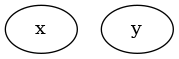

In [63]:
from IPython.display import Image
Image("/home/sdjtei/Study/deep-learning-from-scratch-3/sample.png")